# Imputation Research Project <img src="https://miro.medium.com/max/1400/1*JPZcoAD9kERfEQxwlaPT-A.jpeg" alt="Alt text image not displaying" width="500" align="right" />
## Notebook 1.1: Exploratory Data Analysis

**Author:** Chike Odenigbo

**Date:** November 25th, 2022

**Notebook Structure:**

* 1.0 Preprocessing

* **1.1 Exploratory Data Analysis**

* 1.2 Masking

* 2.* Models


Water Sugar Alcohol

In [47]:
# DOCUMENTATION: https://rianneschouten.github.io/pyampute/build/html/pyampute.ampute.html
from pyampute.ampute import MultivariateAmputation
from pyampute.exploration.mcar_statistical_tests import MCARTest
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import rpy2.robjects as robjects
# from rpy2.robjects.packages import importr
# from rpy2.robjects import pandas2ri
# from rpy2.robjects import globalenv

import pandas as pd
# from scipy.stats import variation
# from src.preprocessing.preprocessing import NumericalVariableCleaner, NumericalMasker # utility preprocessing packages found in src folder
import os
from src.visualization.visualize import histogram, box_plot, bar_plot
# from itertools import chain, combinations
from pathlib import Path
from notebook_config import ROOT_DIR # setup.py file changed the root of the project so it is set in the config file
ROOT_DIR = ROOT_DIR.as_posix() # convert root path to windows readable path (i.e. change backslash to forward slash)
# import json
import numpy as np
# import functools as ft

In [4]:
notebook_nm = '2.1-masking'
fig_dir = f'{ROOT_DIR}/reports/figures/'
output_prefix = notebook_nm

In [45]:
# nutrition_df.drop(['name','serving_size'],axis='columns')
def ampute(df, target_col, mechanism, prop = 0.2, seed = 1): 
    ma = MultivariateAmputation(prop = 0.2, patterns = [{'incomplete_vars':['water'] ,'mechanism':'MCAR'}],verbose = False, seed = seed)
    output_df = ma.fit_transform(df)
    return output_df

In [27]:
pd.set_option('display.max_columns', None)
nutrition_df = pd.read_csv(f'{ROOT_DIR}/data/interim/nutrition_numerical.csv').dropna(axis = 'rows').reset_index(drop = True)

# ma = MultivariateAmputation(prop = 0.2, patterns = [{'incomplete_vars':['water'] ,'mechanism':'MCAR'}],verbose = True)
# na_water_df = ma.fit_transform(nutrition_df.drop(['name','serving_size'],axis='columns'))
# na_water_df

In [42]:
mcar_water_df = ampute(nutrition_df.drop(['name','serving_size'],axis='columns'), 'water', mechanism = 'MCAR', prop = 0.2, seed = 20)
mnar_water_df = ampute(nutrition_df.drop(['name','serving_size'],axis='columns'), 'water', mechanism = 'MNAR', prop = 0.2, seed = 20)
mar_water_df = ampute(nutrition_df.drop(['name','serving_size'],axis='columns'), 'water', mechanism = 'MAR', prop = 0.2, seed = 20)

mt = MCARTest(method="little")
print(f'MCAR Test water mcar: {mt.little_mcar_test(mcar_water_df)}')
print(f'MCAR Test water mnar: {mt.little_mcar_test(mnar_water_df)}')
print(f'MCAR Test water mar: {mt.little_mcar_test(mar_water_df)}')

2022-11-25 22:09:09,894 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:09:10,109 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:09:10,295 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


MCAR Test water mcar: 1.0
MCAR Test water mnar: 1.0
MCAR Test water mar: 1.0


In [49]:
result_cols = ['column','mcar_test_mcar','mcar_test_mnar','mcar_test_mar']
df = pd.DataFrame(columns=result_cols)
appended_data = [df]
for col in nutrition_df.drop(['name','serving_size'],axis='columns').columns:
    print(col)
    mcar_df = ampute(nutrition_df.drop(['name','serving_size'],axis='columns'), col, mechanism = 'MCAR', prop = 0.2, seed = 20)
    mnar_df = ampute(nutrition_df.drop(['name','serving_size'],axis='columns'), col, mechanism = 'MNAR', prop = 0.2, seed = 20)
    mar_df = ampute(nutrition_df.drop(['name','serving_size'],axis='columns'), col, mechanism = 'MAR', prop = 0.2, seed = 20)
    mcar_p_val = mt.little_mcar_test(mcar_df)
    mnar_p_val = mt.little_mcar_test(mnar_df)
    mar_p_val = mt.little_mcar_test(mar_df)
#     print(f'MCAR Test {col} mcar: {mcar_p_val}')
#     print(f'MCAR Test {col} mnar: {mnar_p_val}')
#     print(f'MCAR Test {col} mar: {mar_p_val}')
    data = pd.DataFrame([[col,mcar_p_val, mnar_p_val ,mar_p_val]], columns=result_cols)
    # store DataFrame in list
    appended_data.append(data)
# see pd.concat documentation for more info
appended_data = pd.concat(appended_data)
appended_data

2022-11-25 22:24:24,868 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


total_fat


2022-11-25 22:24:25,066 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:25,264 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:26,568 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:26,753 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

saturated_fat


2022-11-25 22:24:26,900 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:28,291 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:28,461 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


cholesterol


2022-11-25 22:24:28,650 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:29,866 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:30,029 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


sodium


2022-11-25 22:24:30,196 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:31,398 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:31,576 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


choline


2022-11-25 22:24:31,762 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:33,196 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


folate


2022-11-25 22:24:33,446 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:33,641 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:34,945 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:35,116 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

folic_acid


2022-11-25 22:24:35,294 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:36,678 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:36,858 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


niacin


2022-11-25 22:24:37,049 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:38,315 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:38,503 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


pantothenic_acid


2022-11-25 22:24:38,682 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:40,020 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:40,218 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


riboflavin


2022-11-25 22:24:40,423 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:41,827 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:42,003 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


thiamin


2022-11-25 22:24:42,172 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:43,542 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:43,685 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


vitamin_a


2022-11-25 22:24:43,870 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:45,149 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:45,347 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


vitamin_a_rae


2022-11-25 22:24:45,537 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:46,846 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:47,037 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


carotene_alpha


2022-11-25 22:24:47,215 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:48,453 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:48,631 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


carotene_beta


2022-11-25 22:24:48,830 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:49,999 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:50,178 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


cryptoxanthin_beta


2022-11-25 22:24:50,369 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:51,677 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:51,846 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


lutein_zeaxanthin


2022-11-25 22:24:52,042 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:53,267 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:53,434 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


vitamin_b12


2022-11-25 22:24:53,610 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:54,726 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:54,907 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


vitamin_b6


2022-11-25 22:24:55,092 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:56,346 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:56,524 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


vitamin_c


2022-11-25 22:24:56,711 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:57,934 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:58,120 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


vitamin_d


2022-11-25 22:24:58,306 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:59,584 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:24:59,766 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


vitamin_e


2022-11-25 22:24:59,924 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:01,248 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:01,434 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


tocopherol_alpha


2022-11-25 22:25:01,603 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:02,887 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:03,084 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


vitamin_k


2022-11-25 22:25:03,276 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:04,853 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:05,030 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


calcium


2022-11-25 22:25:05,183 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:06,412 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:06,595 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


copper


2022-11-25 22:25:06,764 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:07,998 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:08,180 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


irom


2022-11-25 22:25:08,362 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:09,545 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


magnesium


2022-11-25 22:25:09,746 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:09,917 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:11,173 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:11,372 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

manganese


2022-11-25 22:25:11,539 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:12,806 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:12,977 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


phosphorous


2022-11-25 22:25:13,159 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:14,406 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


potassium


2022-11-25 22:25:14,611 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:14,815 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:16,027 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:16,215 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

selenium


2022-11-25 22:25:16,375 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:17,633 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:17,819 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


zink


2022-11-25 22:25:17,986 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:19,255 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:19,421 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


protein


2022-11-25 22:25:19,603 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:20,841 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:21,019 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


alanine


2022-11-25 22:25:21,186 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:22,362 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:22,535 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


arginine


2022-11-25 22:25:22,724 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:24,288 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


aspartic_acid


2022-11-25 22:25:24,506 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:24,727 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:26,317 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:26,497 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

cystine


2022-11-25 22:25:26,686 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:28,001 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:28,147 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


glutamic_acid


2022-11-25 22:25:28,314 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:29,512 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:29,695 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


glycine


2022-11-25 22:25:29,878 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:31,258 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:31,445 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


histidine


2022-11-25 22:25:31,633 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:32,850 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:33,008 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


hydroxyproline


2022-11-25 22:25:33,211 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:34,463 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:34,636 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


isoleucine


2022-11-25 22:25:34,825 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:36,078 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:36,282 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


leucine


2022-11-25 22:25:36,482 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:37,663 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:37,837 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


lysine


2022-11-25 22:25:38,022 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:39,426 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


methionine


2022-11-25 22:25:39,642 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:39,812 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:41,419 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:41,611 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

phenylalanine


2022-11-25 22:25:41,797 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:43,425 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:43,602 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


proline


2022-11-25 22:25:43,807 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:45,274 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


serine


2022-11-25 22:25:45,485 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:45,690 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:47,247 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


threonine


2022-11-25 22:25:47,562 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:47,801 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:49,121 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:49,297 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

tryptophan


2022-11-25 22:25:49,479 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:50,846 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:51,036 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


tyrosine


2022-11-25 22:25:51,227 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:52,493 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


valine


2022-11-25 22:25:52,686 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:52,898 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:54,541 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


carbohydrate


2022-11-25 22:25:54,762 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:54,968 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:56,549 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:56,744 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

fiber


2022-11-25 22:25:56,948 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:58,589 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


sugars


2022-11-25 22:25:58,826 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:25:59,036 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:00,671 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:00,873 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

fructose


2022-11-25 22:26:01,067 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:02,289 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:02,464 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


galactose


2022-11-25 22:26:02,617 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:03,832 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:03,980 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


glucose


2022-11-25 22:26:04,168 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:05,332 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:05,527 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


lactose


2022-11-25 22:26:05,697 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:06,913 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:07,095 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


maltose


2022-11-25 22:26:07,301 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:08,438 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:08,631 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


sucrose


2022-11-25 22:26:08,816 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:10,236 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:10,391 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


fat


2022-11-25 22:26:10,573 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:11,973 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:12,158 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


saturated_fatty_acids


2022-11-25 22:26:12,336 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:13,832 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:14,018 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


monounsaturated_fatty_acids


2022-11-25 22:26:14,210 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:15,678 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:15,857 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


polyunsaturated_fatty_acids


2022-11-25 22:26:16,009 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:17,280 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:17,448 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


fatty_acids_total_trans


2022-11-25 22:26:17,609 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:19,022 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


alcohol


2022-11-25 22:26:19,221 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:19,389 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:20,641 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:20,801 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

ash


2022-11-25 22:26:20,974 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:22,239 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:22,400 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


caffeine


2022-11-25 22:26:22,599 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:23,881 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:24,053 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


theobromine


2022-11-25 22:26:24,229 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:25,457 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-25 22:26:25,625 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


water


2022-11-25 22:26:25,818 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


,column,mcar_test_mcar,mcar_test_mnar,mcar_test_mar
0,total_fat,1.0,1.0,1.0
0,saturated_fat,1.0,1.0,1.0
0,cholesterol,1.0,1.0,1.0
0,sodium,1.0,1.0,1.0
0,choline,1.0,1.0,1.0
...,...,...,...,...
0,alcohol,1.0,1.0,1.0
0,ash,1.0,1.0,1.0
0,caffeine,1.0,1.0,1.0
0,theobromine,1.0,1.0,1.0


In [ ]:
appended_data.nsmallest('mcar_test')

In [15]:
na_water_df['water'].isnull().sum() / na_water_df.shape[0]

0.2097513543547715

In [10]:
na_water_df.shape[0]

7199

In [3]:
def convert_masked_rows_to_na(mask_df,target_col):
    output_df = mask_df
#     output_df[target_col] = output_df[target_col].where(output_df[f'mask_ind_{target_col}'] != 1)
    output_df[f'{target_col}_na'] = np.where(output_df[f'mask_ind_{target_col}'] == 1, np.nan, output_df[target_col])
#     output_df[f'{target_col}'] = np.where(output_df[f'mask_ind_{target_col}'] == 1, np.nan, output_df[target_col])
    output_df = output_df.drop([f'mask_ind_{target_col}', target_col], axis=1)
#     output_df[f'{target_col}_na'].name = target_col
    output_df.rename(columns = {f'{target_col}_na':target_col}, inplace = True)
    return output_df

In [4]:
pd.set_option('display.max_columns', None)
nutrition_df = pd.read_csv(f'{ROOT_DIR}/data/interim/nutrition_numerical.csv').dropna(axis = 'rows').reset_index(drop = True)
nutrition_df

,name,serving_size,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,niacin,pantothenic_acid,riboflavin,thiamin,vitamin_a,vitamin_a_rae,carotene_alpha,carotene_beta,cryptoxanthin_beta,lutein_zeaxanthin,vitamin_b12,vitamin_b6,vitamin_c,vitamin_d,vitamin_e,tocopherol_alpha,vitamin_k,calcium,copper,irom,magnesium,manganese,phosphorous,potassium,selenium,zink,protein,alanine,arginine,aspartic_acid,cystine,glutamic_acid,glycine,histidine,hydroxyproline,isoleucine,leucine,lysine,methionine,phenylalanine,proline,serine,threonine,tryptophan,tyrosine,valine,carbohydrate,fiber,sugars,fructose,galactose,glucose,lactose,maltose,sucrose,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water
0,"Nuts, pecans",100,72.0,6.2,0,0.0,40.5,22.0,0.0,1.167,0.863,0.130,0.660,56.0,3.0,0.0,29.0,9.0,17.0,0.00,0.210,1.1,0.0,1.40,1.40,3.5,70.0,1.200,2.53,121.0,4.500,277.0,410.0,3.8,4.53,9.17,0.397,1.177,0.929,0.152,1.829,0.453,0.262,0.000,0.336,0.598,0.287,0.183,0.426,0.363,0.474,0.306,0.093,0.215,0.411,13.86,9.6,3.97,0.04,0.0,0.04,0.0,0.00,3.90,71.97,6.180,40.801,21.614,0.0,0.0,1.49,0.0,0.0,3.52
1,"Teff, uncooked",100,2.4,0.4,0,12.0,13.1,0.0,0.0,3.363,0.942,0.270,0.390,9.0,0.0,0.0,5.0,0.0,66.0,0.00,0.482,0.0,0.0,0.08,0.08,1.9,180.0,0.810,7.63,184.0,9.240,429.0,427.0,4.4,3.63,13.30,0.747,0.517,0.820,0.236,3.349,0.477,0.301,0.000,0.501,1.068,0.376,0.428,0.698,0.664,0.622,0.510,0.139,0.458,0.686,73.13,8.0,1.84,0.47,0.0,0.73,0.0,0.01,0.62,2.38,0.449,0.589,1.071,0.0,0.0,2.37,0.0,0.0,8.82
2,"Sherbet, orange",100,2.0,1.2,1,46.0,7.7,4.0,0.0,0.063,0.224,0.097,0.027,46.0,12.0,0.0,1.0,5.0,7.0,0.13,0.023,2.3,0.0,0.01,0.01,0.0,54.0,0.028,0.14,8.0,0.011,40.0,96.0,1.5,0.48,1.10,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,30.40,1.3,24.32,0.00,0.0,0.00,0.0,0.00,0.00,2.00,1.160,0.530,0.080,1.0,0.0,0.40,0.0,0.0,66.10
3,"Cauliflower, raw",100,0.3,0.1,0,30.0,44.3,57.0,0.0,0.507,0.667,0.060,0.050,0.0,0.0,0.0,0.0,0.0,1.0,0.00,0.184,48.2,0.0,0.08,0.08,15.5,22.0,0.039,0.42,15.0,0.155,44.0,299.0,0.6,0.27,1.92,0.116,0.086,0.177,0.020,0.257,0.071,0.056,0.000,0.071,0.106,0.217,0.020,0.065,0.071,0.086,0.076,0.020,0.051,0.125,4.97,2.0,1.91,0.97,0.0,0.94,0.0,0.00,0.00,0.28,0.130,0.034,0.031,0.0,0.0,0.76,0.0,0.0,92.07
4,"Taro leaves, raw",100,0.7,0.2,0,3.0,12.8,126.0,0.0,1.513,0.084,0.456,0.209,4825.0,241.0,0.0,2895.0,0.0,1932.0,0.00,0.146,52.0,0.0,2.02,2.02,108.6,107.0,0.270,2.25,45.0,0.714,60.0,648.0,0.9,0.41,4.98,0.000,0.220,0.000,0.064,0.000,0.000,0.114,0.000,0.260,0.392,0.246,0.079,0.195,0.000,0.000,0.167,0.048,0.178,0.256,6.70,3.7,3.01,0.00,0.0,0.00,0.0,0.00,0.00,0.74,0.151,0.060,0.307,0.0,0.0,1.92,0.0,0.0,85.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7194,"Beef, raw, all grades, trimmed to 0"" fat, sepa...",100,3.5,1.4,62,54.0,64.5,4.0,0.0,6.422,0.356,0.234,0.063,11.0,3.0,0.0,0.0,0.0,0.0,1.64,0.631,0.0,1.0,0.23,0.23,1.5,13.0,0.048,2.33,12.0,0.004,219.0,311.0,22.1,3.67,23.45,1.454,1.597,2.285,0.239,3.834,1.154,0.879,0.160,1.092,2.021,2.246,0.635,0.941,1.052,0.966,1.105,0.262,0.874,1.172,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,3.50,1.353,1.554,0.244,62.0,0.0,1.11,0.0,0.0,72.51
7195,"Lamb, cooked, separable lean only, composite o...",100,8.9,3.9,109,50.0,0.0,0.0,0.0,7.680,0.580,0.500,0.130,0.0,0.0,0.0,0.0,0.0,0.0,2.95,0.140,0.0,0.0,0.19,0.19,0.0,13.0,0.114,2.35,22.0,0.029,246.0,188.0,2.0,4.30,29.59,1.780,1.758,2.605,0.353,4.294,1.445,0.937,0.000,1.428,2.302,2.613,0.759,1.205,1.241,1.100,1.267,0.346,0.995,1.597,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,8.86,3.860,3.480,0.520,109.0,0.0,1.60,0.0,0.0,59.95
7196,"Lamb, raw, separable lean and fat, composit

In [5]:
masker = NumericalMasker()
mask_water_df = masker.mask(nutrition_df, 'water', k = 1, n = None, no_cols_frac = None, no_cols = 2, prob_range_non_mask = (0,0.3), prob_range_mask = (0.9,1), frac_na=0.2, rank_method = 'first', normalize_weights = False, selected_cols = None, seed = None,  max_corr = 0.9, min_corr = 0.3, col_weights = None)
mask_water_df[mask_water_df['mask_ind_water']==1]
na_water_df = convert_masked_rows_to_na(mask_water_df,'water')
na_water_df[na_water_df['water'].isnull()]

INFO:root:Starting masking process for the water field.
INFO:root:Selecting key columns.
INFO:root:Masking 1439 rows which make up for 19.99% of the observations into 1 clusters.
INFO:root:Finished creating correlation matrix.
INFO:root:Finished creating ranking matrix.
INFO:root:Finished ordering similar rows.
INFO:root:Finished creating clusters in the dataframe.
INFO:root:Finished creating index weights.


,name,serving_size,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,niacin,pantothenic_acid,riboflavin,thiamin,vitamin_a,vitamin_a_rae,carotene_alpha,carotene_beta,cryptoxanthin_beta,lutein_zeaxanthin,vitamin_b12,vitamin_b6,vitamin_c,vitamin_d,vitamin_e,tocopherol_alpha,vitamin_k,calcium,copper,irom,magnesium,manganese,phosphorous,potassium,selenium,zink,protein,alanine,arginine,aspartic_acid,cystine,glutamic_acid,glycine,histidine,hydroxyproline,isoleucine,leucine,lysine,methionine,phenylalanine,proline,serine,threonine,tryptophan,tyrosine,valine,carbohydrate,fiber,sugars,fructose,galactose,glucose,lactose,maltose,sucrose,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water
5,"Lamb, raw, ground",100,23.0,10.0,73,59.0,69.3,18.0,0.0,5.960,0.650,0.210,0.110,0.0,0.0,0.0,0.0,0.0,0.0,2.31,0.130,0.0,2.0,0.20,0.20,3.6,16.0,0.101,1.55,21.0,0.019,157.0,222.0,18.8,3.41,16.56,0.996,0.984,1.457,0.198,2.402,0.809,0.524,0.000,0.799,1.288,1.462,0.425,0.674,0.694,0.615,0.709,0.193,0.556,0.893,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,23.41,10.190,9.600,1.850,73.0,0.0,0.87,0.0,0.0,NaN
12,"Peppers, raw, jalapeno",100,0.4,0.1,0,3.0,7.5,27.0,0.0,1.280,0.315,0.070,0.040,1078.0,54.0,67.0,561.0,105.0,861.0,0.00,0.419,118.6,0.0,3.58,3.58,18.5,12.0,0.046,0.25,15.0,0.097,26.0,248.0,0.4,0.14,0.91,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,6.50,2.8,4.12,2.63,0.0,1.48,0.0,0.0,0.0,0.37,0.092,0.029,0.112,0.0,0.0,0.53,0.0,0.0,NaN
23,"Cookies, Marie biscuit",100,11.0,5.3,0,370.0,27.0,118.0,98.0,3.861,0.000,0.493,0.541,3.0,1.0,0.0,0.0,0.0,12.0,0.19,0.074,0.0,0.0,0.45,0.45,3.8,0.0,0.101,0.00,28.0,0.000,193.0,307.0,23.9,0.61,7.05,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,70.54,3.5,21.16,0.00,0.0,0.00,0.0,0.0,0.0,10.58,5.291,2.694,1.670,0.0,0.0,2.03,0.0,0.0,NaN
29,"Gravy, mix, dry, onion",100,3.0,1.9,2,4186.0,0.0,31.0,17.0,3.700,0.100,0.400,0.200,0.0,0.0,0.0,0.0,0.0,0.0,0.70,0.100,7.0,0.0,0.00,0.00,0.0,280.0,0.170,1.00,34.0,0.400,203.0,262.0,6.1,0.88,9.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,67.64,6.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,3.00,1.860,0.900,0.140,2.0,0.0,16.00,0.0,0.0,NaN
40,"Egg custards, dry mix",100,6.4,2.0,258,281.0,0.0,30.0,0.0,0.320,2.238,0.412,0.145,217.0,63.0,0.0,0.0,0.0,0.0,1.17,0.216,0.4,0.0,0.00,0.00,0.0,228.0,0.046,1.93,45.0,0.020,332.0,540.0,16.6,1.05,6.90,0.341,0.361,0.681,0.130,1.031,0.185,0.156,0.000,0.368,0.623,0.553,0.153,0.261,0.351,0.475,0.401,0.094,0.257,0.381,82.80,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,6.40,2.030,2.400,0.850,258.0,0.0,2.20,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7168,"Beef, braised, cooked, choice, trimmed to 0"" f...",100,8.3,2.8,97,60.0,100.6,8.0,0.0,4.923,0.830,0.282,0.080,5.0,1.0,0.0,0.0,0.0,0.0,3.38,0.512,0.0,6.0,0.13,0.13,1.6,13.0,0.140,3.76,25.0,0.015,234.0,358.0,38.6,9.39,31.32,1.811,2.106,2.884,0.333,5.101,1.395,1.033,0.158,1.371,2.593,2.818,0.914,1.221,1.289,1.230,1.418,0.359,1.111,1.449,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,8.30,2.835,3.757,0.470,97.0,0.0,1.42,0.0,0.0,NaN
7180,"Beef, grilled, cooked, all grades, trimmed to ...",100,5.8,2.4,82,68.0,88.7,7.0,0.0,5.542,0.790,0.225,0.090,5.0,2.0,0.0,0.0,0.0,0.0,3.43,0.678,0.0,5.0,0.10,0.10,1.6,12.0,0.105,2.94,26.0,0.013,249.0,372.0,32.0,8.19,28.60,1.653,1.924,2.633,0.304,4.658,1.274,0.944,0.144,1.252,2.368,2.573,0.834,1.115,1.177,1.124,1.295,0.328,1.014,1.323,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,5.82,2.430,2.980,0.360,82.0,0.0,1.23,0.0,0.0,NaN
7186,"Beef, broiled, coo

In [6]:
nutrition_df[nutrition_df.water.isnull()]

,name,serving_size,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,niacin,pantothenic_acid,riboflavin,thiamin,vitamin_a,vitamin_a_rae,carotene_alpha,carotene_beta,cryptoxanthin_beta,lutein_zeaxanthin,vitamin_b12,vitamin_b6,vitamin_c,vitamin_d,vitamin_e,tocopherol_alpha,vitamin_k,calcium,copper,irom,magnesium,manganese,phosphorous,potassium,selenium,zink,protein,alanine,arginine,aspartic_acid,cystine,glutamic_acid,glycine,histidine,hydroxyproline,isoleucine,leucine,lysine,methionine,phenylalanine,proline,serine,threonine,tryptophan,tyrosine,valine,carbohydrate,fiber,sugars,fructose,galactose,glucose,lactose,maltose,sucrose,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water


In [8]:
# mask_water_df[mask_water_df.water_new.isnull()]

Image found in the "reports/figures" folder saved under 2.0-masking-water-distribution_water_hist.png


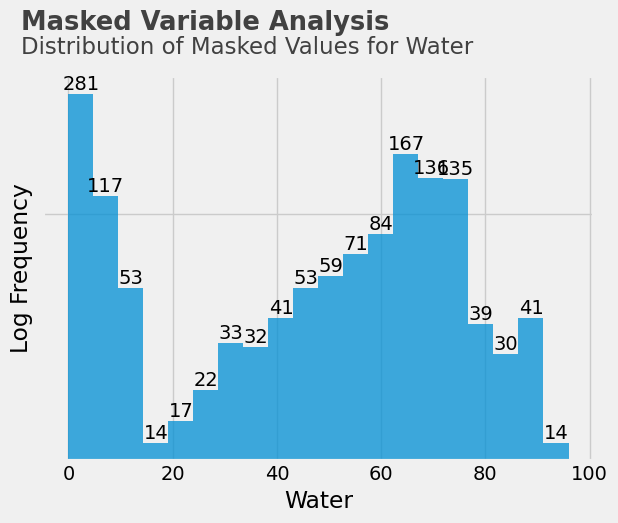

In [9]:
histogram(df = mask_water_df[mask_water_df['mask_ind_water']==1], col = 'water',output_prefix = f'{notebook_nm}-water-distribution',fig_dir = fig_dir, title = 'Masked Variable Analysis', subtitle = 'Distribution of Masked Values for Water', bins = 20, log_scale = True)

In [10]:
masker._corr_matrix['water'].nlargest(10)

water                          1.000000
carbohydrate                   0.785348
sugars                         0.497932
total_fat                      0.457254
fat                            0.457253
fiber                          0.414657
polyunsaturated_fatty_acids    0.388177
magnesium                      0.380786
monounsaturated_fatty_acids    0.358298
folate                         0.349385
Name: water, dtype: float64

In [11]:
masker._similar_ordered_index

,original_index,score
0,4156,0.410755
1,440,0.419895
2,2028,0.421934
3,2714,0.422724
4,1827,0.423950
...,...,...
7194,6467,1.709007
7195,6418,1.719070
7196,6440,1.720736
7197,7192,1.771358


In [12]:
masker = NumericalMasker()
mask_sugar_df = masker.mask(nutrition_df, 'sugars', k = 2, n = None, no_cols_frac = None, no_cols = 4, prob_range_non_mask = (0,0.3), prob_range_mask = (0.7,1), frac_na=0.2, rank_method = 'first', normalize_weights = False, selected_cols = None, seed = None,  max_corr = 0.9, min_corr = 0.3, col_weights = None)
mask_sugar_df[mask_sugar_df['mask_ind_sugars']==1]
na_sugar_df = convert_masked_rows_to_na(mask_sugar_df,'sugars')
na_sugar_df

INFO:root:Starting masking process for the sugars field.
INFO:root:Selecting key columns.
INFO:root:Masking 1439 rows which make up for 19.99% of the observations into 2 clusters.
INFO:root:Finished creating correlation matrix.
INFO:root:Finished creating ranking matrix.
INFO:root:Finished ordering similar rows.
INFO:root:Finished creating clusters in the dataframe.
INFO:root:Finished creating index weights.


,name,serving_size,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,niacin,pantothenic_acid,riboflavin,thiamin,vitamin_a,vitamin_a_rae,carotene_alpha,carotene_beta,cryptoxanthin_beta,lutein_zeaxanthin,vitamin_b12,vitamin_b6,vitamin_c,vitamin_d,vitamin_e,tocopherol_alpha,vitamin_k,calcium,copper,irom,magnesium,manganese,phosphorous,potassium,selenium,zink,protein,alanine,arginine,aspartic_acid,cystine,glutamic_acid,glycine,histidine,hydroxyproline,isoleucine,leucine,lysine,methionine,phenylalanine,proline,serine,threonine,tryptophan,tyrosine,valine,carbohydrate,fiber,fructose,galactose,glucose,lactose,maltose,sucrose,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water,sugars
0,"Nuts, pecans",100,72.0,6.2,0,0.0,40.5,22.0,0.0,1.167,0.863,0.130,0.660,56.0,3.0,0.0,29.0,9.0,17.0,0.00,0.210,1.1,0.0,1.40,1.40,3.5,70.0,1.200,2.53,121.0,4.500,277.0,410.0,3.8,4.53,9.17,0.397,1.177,0.929,0.152,1.829,0.453,0.262,0.000,0.336,0.598,0.287,0.183,0.426,0.363,0.474,0.306,0.093,0.215,0.411,13.86,9.6,0.04,0.0,0.04,0.0,0.00,3.90,71.97,6.180,40.801,21.614,0.0,0.0,1.49,0.0,0.0,3.52,3.97
1,"Teff, uncooked",100,2.4,0.4,0,12.0,13.1,0.0,0.0,3.363,0.942,0.270,0.390,9.0,0.0,0.0,5.0,0.0,66.0,0.00,0.482,0.0,0.0,0.08,0.08,1.9,180.0,0.810,7.63,184.0,9.240,429.0,427.0,4.4,3.63,13.30,0.747,0.517,0.820,0.236,3.349,0.477,0.301,0.000,0.501,1.068,0.376,0.428,0.698,0.664,0.622,0.510,0.139,0.458,0.686,73.13,8.0,0.47,0.0,0.73,0.0,0.01,0.62,2.38,0.449,0.589,1.071,0.0,0.0,2.37,0.0,0.0,8.82,1.84
2,"Sherbet, orange",100,2.0,1.2,1,46.0,7.7,4.0,0.0,0.063,0.224,0.097,0.027,46.0,12.0,0.0,1.0,5.0,7.0,0.13,0.023,2.3,0.0,0.01,0.01,0.0,54.0,0.028,0.14,8.0,0.011,40.0,96.0,1.5,0.48,1.10,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,30.40,1.3,0.00,0.0,0.00,0.0,0.00,0.00,2.00,1.160,0.530,0.080,1.0,0.0,0.40,0.0,0.0,66.10,24.32
3,"Cauliflower, raw",100,0.3,0.1,0,30.0,44.3,57.0,0.0,0.507,0.667,0.060,0.050,0.0,0.0,0.0,0.0,0.0,1.0,0.00,0.184,48.2,0.0,0.08,0.08,15.5,22.0,0.039,0.42,15.0,0.155,44.0,299.0,0.6,0.27,1.92,0.116,0.086,0.177,0.020,0.257,0.071,0.056,0.000,0.071,0.106,0.217,0.020,0.065,0.071,0.086,0.076,0.020,0.051,0.125,4.97,2.0,0.97,0.0,0.94,0.0,0.00,0.00,0.28,0.130,0.034,0.031,0.0,0.0,0.76,0.0,0.0,92.07,1.91
4,"Taro leaves, raw",100,0.7,0.2,0,3.0,12.8,126.0,0.0,1.513,0.084,0.456,0.209,4825.0,241.0,0.0,2895.0,0.0,1932.0,0.00,0.146,52.0,0.0,2.02,2.02,108.6,107.0,0.270,2.25,45.0,0.714,60.0,648.0,0.9,0.41,4.98,0.000,0.220,0.000,0.064,0.000,0.000,0.114,0.000,0.260,0.392,0.246,0.079,0.195,0.000,0.000,0.167,0.048,0.178,0.256,6.70,3.7,0.00,0.0,0.00,0.0,0.00,0.00,0.74,0.151,0.060,0.307,0.0,0.0,1.92,0.0,0.0,85.66,3.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7194,"Beef, raw, all grades, trimmed to 0"" fat, sepa...",100,3.5,1.4,62,54.0,64.5,4.0,0.0,6.422,0.356,0.234,0.063,11.0,3.0,0.0,0.0,0.0,0.0,1.64,0.631,0.0,1.0,0.23,0.23,1.5,13.0,0.048,2.33,12.0,0.004,219.0,311.0,22.1,3.67,23.45,1.454,1.597,2.285,0.239,3.834,1.154,0.879,0.160,1.092,2.021,2.246,0.635,0.941,1.052,0.966,1.105,0.262,0.874,1.172,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,3.50,1.353,1.554,0.244,62.0,0.0,1.11,0.0,0.0,72.51,0.00
7195,"Lamb, cooked, separable lean only, composite o...",100,8.9,3.9,109,50.0,0.0,0.0,0.0,7.680,0.580,0.500,0.130,0.0,0.0,0.0,0.0,0.0,0.0,2.95,0.140,0.0,0.0,0.19,0.19,0.0,13.0,0.114,2.35,22.0,0.029,246.0,188.0,2.0,4.30,29.59,1.780,1.758,2.605,0.353,4.294,1.445,0.937,0.000,1.428,2.302,2.613,0.759,1.205,1.241,1.100,1.267,0.346,0.995,1.597,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,8.86,3.860,3.480,0.520,109.0,0.0,1.60,0.0,0.0,59.95,0.00
7196,"Lamb, raw, separable lean and fat, composit

Image found in the "reports/figures" folder saved under 2.0-masking-sugars-distribution_sugars_hist.png


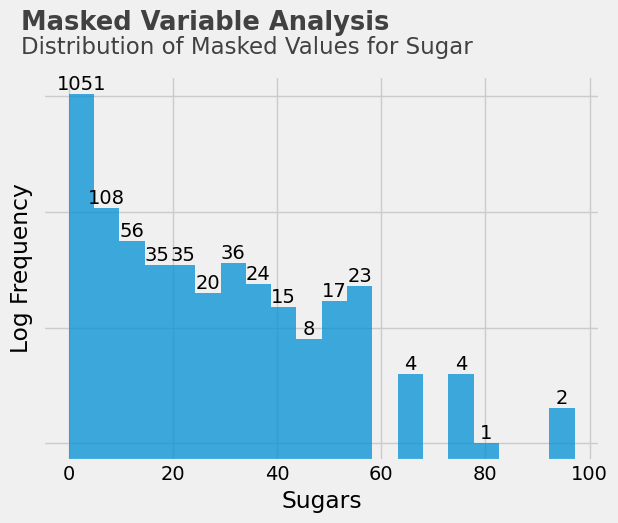

In [13]:
histogram(df = mask_sugar_df[mask_sugar_df['mask_ind_sugars']==1], col = 'sugars',output_prefix = f'{notebook_nm}-sugars-distribution',fig_dir = fig_dir, title = 'Masked Variable Analysis', subtitle = 'Distribution of Masked Values for Sugar', bins = 20, log_scale = True)

In [14]:
masker = NumericalMasker()
mask_alcohol_df = masker.mask(nutrition_df, 'alcohol', k = 10, n = None, no_cols_frac = None, no_cols = 1, prob_range_non_mask = (0,0.3), prob_range_mask = (0.7,1), frac_na=0.2, rank_method = 'first', normalize_weights = False, selected_cols = None, seed = None,  max_corr = 0.9, min_corr = 0.3, col_weights = None)
mask_alcohol_df[mask_alcohol_df['mask_ind_alcohol']==1]
na_alcohol_df = convert_masked_rows_to_na(mask_alcohol_df,'alcohol')

INFO:root:Starting masking process for the alcohol field.
INFO:root:Selecting key columns.
INFO:root:Masking 1439 rows which make up for 19.99% of the observations into 10 clusters.
INFO:root:Finished creating correlation matrix.
INFO:root:Finished creating ranking matrix.
INFO:root:Finished ordering similar rows.
INFO:root:Finished creating clusters in the dataframe.
INFO:root:Finished creating index weights.


Image found in the "reports/figures" folder saved under 2.0-masking-alcohol-distribution_alcohol_hist.png


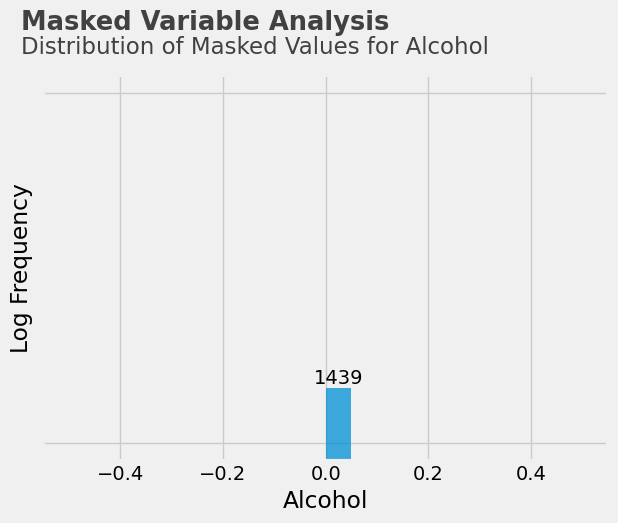

In [15]:
histogram(df = mask_alcohol_df[mask_alcohol_df['mask_ind_alcohol']==1], col = 'alcohol',output_prefix = f'{notebook_nm}-alcohol-distribution',fig_dir = fig_dir, title = 'Masked Variable Analysis', subtitle = 'Distribution of Masked Values for Alcohol', bins = 20, log_scale = True)

In [16]:
# Import R's base package
base = importr("base")

# Import R's utility packages
utils = importr("utils")

# Select mirror 
utils.chooseCRANmirror(ind=1)

# For automatic translation of Pandas objects to R
pandas2ri.activate()

# Enable R magic
%load_ext rpy2.ipython

globalenv["r_mask_alcohol_df"] = na_alcohol_df
globalenv["r_mask_sugar_df"] = na_sugar_df
globalenv["r_mask_water_df"] = na_water_df

In [17]:
# utils.install_packages("remotes")
# %R remotes::install_github("njtierney/naniar")

In [18]:
%R library(naniar)

'naniar','tools','stats',...,'datasets','methods','base'


In [19]:
# globalenv["r_mask_alcohol_df"] = mask_alcohol_df
# globalenv["r_mask_sugar_df"] = mask_sugar_df
# globalenv["r_mask_water_df"] = mask_water_df

In [24]:
# %R mcar_test(r_mask_alcohol_df[c("saturated_fat")])
%R mcar_test(r_mask_alcohol_df[c("alcohol")])
# %R mcar_test(r_mask_alcohol_df)

,statistic,df,p.value,missing.patterns
1,1.837553e-27,0.0,0.0,2


In [21]:
%R mcar_test(r_mask_sugar_df[c("sugars")])

,statistic,df,p.value,missing.patterns
1,1.872327e-26,0.0,0.0,2


In [22]:
%R mcar_test(r_mask_water_df[c("water")])

,statistic,df,p.value,missing.patterns
1,1.207131e-26,0.0,0.0,2
